In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline


data_dir = '/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/'

wv1 = pd.read_csv(
        data_dir + 'regression_data_%s_20210520.csv' % 'wv_cases1')

wv1.head()

,province,industry,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,...,total_demand_plus_7,total_demand_plus_8,total_demand_minus_1,total_demand_minus_2,total_demand_minus_3,total_demand_minus_4,total_demand_minus_5,total_demand_minus_6,total_demand_minus_7,total_demand_minus_8
0,Bangkok,Construction,2018-02,435.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,NaN,NaN,45.0,375.0,71.0,708.0,155.0,100.0,315.0,332.0
1,Bangkok,Food and Beverage,2018-02,30.0,1.0,1.0,5.00602,2018-01-08,2018-01,2018-1,...,NaN,NaN,170.0,0.0,100.0,0.0,0.0,30.0,30.0,15.0
2,Bangkok,Manufacturing,2018-02,50.0,0.0,1.0,5.00602,2018-01-08,2018-01,2018-1,...,NaN,NaN,190.0,214.0,302.0,140.0,834.0,66.0,15.0,120.0
3,Bangkok,Services,2018-02,105.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,NaN,NaN,9.0,0.0,141.0,2.0,0.0,65.0,150.0,176.0
4,Bangkok,Agriculture and Forestry,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,NaN,NaN,0.0,0.0,0.0,0.0,120.0,0.0,0.0,0.0


In [2]:
wv1.columns

Index(['province', 'industry', 'year_week', 'total_demand', 'perc_abuse',
       'wv_count', 'ex_rate', 'fake_date', 'month', 'quarter', 'ex_rate_diff',
       'ex_rate_diff_plus_1', 'ex_rate_diff_plus_2', 'ex_rate_diff_plus_3',
       'ex_rate_diff_plus_4', 'ex_rate_diff_plus_5', 'ex_rate_diff_plus_6',
       'ex_rate_diff_plus_7', 'ex_rate_diff_plus_8', 'ex_rate_diff_minus_1',
       'ex_rate_diff_minus_2', 'ex_rate_diff_minus_3', 'ex_rate_diff_minus_4',
       'ex_rate_diff_minus_5', 'ex_rate_diff_minus_6', 'ex_rate_diff_minus_7',
       'ex_rate_diff_minus_8', 'total_demand_plus_1', 'total_demand_plus_2',
       'total_demand_plus_3', 'total_demand_plus_4', 'total_demand_plus_5',
       'total_demand_plus_6', 'total_demand_plus_7', 'total_demand_plus_8',
       'total_demand_minus_1', 'total_demand_minus_2', 'total_demand_minus_3',
       'total_demand_minus_4', 'total_demand_minus_5', 'total_demand_minus_6',
       'total_demand_minus_7', 'total_demand_minus_8'],
      dtype='obje

## calculate shock

In [3]:
wv_data_file = 'wv_cases1'
df = wv1
df['demand_shock'] = None

for prov in df.province.unique():
    for ind in df.industry.unique():
        prov_row_idx = df[(df.province==prov)&(df.industry==ind)].index 
        demand_data_points = df.loc[prov_row_idx, 'total_demand'].values
        std_demand = np.std(demand_data_points)
        df.loc[[0, 1], 'demand_shock'] = np.nan # need at least two points to fit a line
        
        for time_pointer in range(2, len(prov_row_idx)):
            y = demand_data_points[max(0, time_pointer-4):time_pointer]
            expected_demand = np.mean(y)
            demand_shock = demand_data_points[time_pointer] - expected_demand
    #         print(x, y, expected_demand, demand_shock)
            df.loc[prov_row_idx[time_pointer], 'demand_shock'] = demand_shock/std_demand
    
print(df.shape)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars


(33561, 44)


In [10]:

    # create placeholder
for offset in range(1, 9):
    df['demand_shock_plus_%s' % offset] = None
# shift IV the other way by up to 2 months    
for offset in range(1, 9):
    df['demand_shock_minus_%s' % offset] = None

for prov in df.province.unique():
    for ind in df.industry.unique():
        prov_row_idx = df[(df.province==prov)&(df.industry==ind)].index 

        for offset in range(1, 9):
            df.loc[prov_row_idx, 'demand_shock_plus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(offset)
        # shift IV the other way by up to 2 months    
        for offset in range(1, 9):
            df.loc[prov_row_idx, 'demand_shock_minus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(-offset)
        
print(df.shape)

(33561, 61)


In [12]:
for offset in range(1, 6):
    df['perc_abuse_minus_%s' % offset] = None

for prov in df.province.unique():
    for ind in df.industry.unique():
        prov_row_idx = df[(df.province==prov)&(df.industry==ind)].index 

        for offset in range(1, 6):
            df.loc[prov_row_idx, 'perc_abuse_minus_%s' % offset] = df.loc[prov_row_idx, 'perc_abuse'].shift(-offset)
        # shift IV the other way by up to 2 months    
        
print(df.shape)

(33561, 66)


In [13]:
df.head()

,province,industry,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,...,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float,perc_abuse_minus_1,perc_abuse_minus_2,perc_abuse_minus_3,perc_abuse_minus_4,perc_abuse_minus_5
0,Bangkok,Construction,2018-02,435.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,-0.446895,-0.701602,0.174436,0.038592,2018.02,0,0,0,0,0
1,Bangkok,Food and Beverage,2018-02,30.0,1.0,1.0,5.00602,2018-01-08,2018-01,2018-1,...,-0.720504,0.0533706,-0.0266853,0,2018.02,0.5,0,0,0,0
2,Bangkok,Manufacturing,2018-02,50.0,0.0,1.0,5.00602,2018-01-08,2018-01,2018-1,...,4.58046,-2.25528,-2.35829,-1.05774,2018.02,0,0,0,1,0
3,Bangkok,Services,2018-02,105.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,-0.454974,0.35021,1.17335,1.45771,2018.02,0,0,0,0,0
4,Bangkok,Agriculture and Forestry,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,5.25032,-1.31258,-1.31258,-1.31258,2018.02,0,0,0,0,0


In [14]:
def yr_wk_to_float(yr_wk):
    yr, wk = yr_wk.split('-')
    return int(yr) + float(wk)/100

df['yr_wk_float'] = df.year_week.apply(yr_wk_to_float)

In [15]:
wv_data_file = 'wv_cases1'

df.to_csv(
    data_dir + 'regression_data_%s_causal_ma_detrend_20210520.csv' % wv_data_file, 
    index=False)
df.head()

,province,industry,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,...,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float,perc_abuse_minus_1,perc_abuse_minus_2,perc_abuse_minus_3,perc_abuse_minus_4,perc_abuse_minus_5
0,Bangkok,Construction,2018-02,435.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,-0.446895,-0.701602,0.174436,0.038592,2018.02,0,0,0,0,0
1,Bangkok,Food and Beverage,2018-02,30.0,1.0,1.0,5.00602,2018-01-08,2018-01,2018-1,...,-0.720504,0.0533706,-0.0266853,0,2018.02,0.5,0,0,0,0
2,Bangkok,Manufacturing,2018-02,50.0,0.0,1.0,5.00602,2018-01-08,2018-01,2018-1,...,4.58046,-2.25528,-2.35829,-1.05774,2018.02,0,0,0,1,0
3,Bangkok,Services,2018-02,105.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,-0.454974,0.35021,1.17335,1.45771,2018.02,0,0,0,0,0
4,Bangkok,Agriculture and Forestry,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,...,5.25032,-1.31258,-1.31258,-1.31258,2018.02,0,0,0,0,0


In [8]:
'regression_data_%s_causal_ma_detrend_20210520.csv' % wv_data_file

'regression_data_wv_cases1_causal_ma_detrend_20210520.csv'

In [16]:
df.columns

Index(['province', 'industry', 'year_week', 'total_demand', 'perc_abuse',
       'wv_count', 'ex_rate', 'fake_date', 'month', 'quarter', 'ex_rate_diff',
       'ex_rate_diff_plus_1', 'ex_rate_diff_plus_2', 'ex_rate_diff_plus_3',
       'ex_rate_diff_plus_4', 'ex_rate_diff_plus_5', 'ex_rate_diff_plus_6',
       'ex_rate_diff_plus_7', 'ex_rate_diff_plus_8', 'ex_rate_diff_minus_1',
       'ex_rate_diff_minus_2', 'ex_rate_diff_minus_3', 'ex_rate_diff_minus_4',
       'ex_rate_diff_minus_5', 'ex_rate_diff_minus_6', 'ex_rate_diff_minus_7',
       'ex_rate_diff_minus_8', 'total_demand_plus_1', 'total_demand_plus_2',
       'total_demand_plus_3', 'total_demand_plus_4', 'total_demand_plus_5',
       'total_demand_plus_6', 'total_demand_plus_7', 'total_demand_plus_8',
       'total_demand_minus_1', 'total_demand_minus_2', 'total_demand_minus_3',
       'total_demand_minus_4', 'total_demand_minus_5', 'total_demand_minus_6',
       'total_demand_minus_7', 'total_demand_minus_8', 'demand_shock',
  

In [17]:
df.industry.unique()

array(['Construction', 'Food and Beverage', 'Manufacturing', 'Services',
       'Agriculture and Forestry', 'Mining', 'Packaging', 'Seafood',
       'Waste Management and Recycling'], dtype=object)

## Add USD IV

In [18]:
# folder = '/Users/boyuliu/Dropbox/Boyu-Joann/Data/exchange_rate/China/'
# iv = pd.read_csv(folder + 'weekly_CNY_exchange_rate.csv')
folder = '/Users/boyuliu/Dropbox/Boyu-Joann/Data/exchange_rate/'
iv = pd.read_csv(folder + 'weekly_exchange_rate.csv')
print(iv.year_week.max(), iv.year_week.min(), iv.shape)
iv.head()
# weekly = pd.merge(weekly, iv[['year_week','ex_rate']], on='year_week', how='left')
# weekly.shape

2020-47 2017-01 (203, 3)


,year_week,ex_rate,fake_date
0,2017-01,35.965467,2017-01-01
1,2017-02,35.725580,2017-01-08
2,2017-03,35.546960,2017-01-15
3,2017-04,35.431980,2017-01-22
4,2017-05,35.332080,2017-01-29


In [19]:
iv['month'] = iv['fake_date'].apply(lambda x: x[:-3])
iv['quarter'] = iv['fake_date'].apply(lambda x: x[:5] + str((int(x[5:7])-1)//3 + 1))
iv['ex_rate_diff'] = iv['ex_rate'] - iv['ex_rate'].shift(1)
# shift IV by up to 2 months
for offset in range(1, 9):
    iv['ex_rate_diff_plus_%s' % offset] = iv['ex_rate_diff'].shift(offset)
# shift IV the other way by up to 2 months    
for offset in range(1, 9):
    iv['ex_rate_diff_minus_%s' % offset] = iv['ex_rate_diff'].shift(-offset)
#     iv['ex_rate_diff_%s' % offset] = iv['ex_rate'] - iv['ex_rate'].shift(-offset)    
iv.head()

,year_week,ex_rate,fake_date,month,quarter,ex_rate_diff,ex_rate_diff_plus_1,ex_rate_diff_plus_2,ex_rate_diff_plus_3,ex_rate_diff_plus_4,...,ex_rate_diff_plus_7,ex_rate_diff_plus_8,ex_rate_diff_minus_1,ex_rate_diff_minus_2,ex_rate_diff_minus_3,ex_rate_diff_minus_4,ex_rate_diff_minus_5,ex_rate_diff_minus_6,ex_rate_diff_minus_7,ex_rate_diff_minus_8
0,2017-01,35.965467,2017-01-01,2017-01,2017-1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.239887,-0.17862,-0.11498,-0.09990,-0.12702,-0.02011,-0.00893,-0.04588
1,2017-02,35.725580,2017-01-08,2017-01,2017-1,-0.239887,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.178620,-0.11498,-0.09990,-0.12702,-0.02011,-0.00893,-0.04588,0.22930
2,2017-03,35.546960,2017-01-15,2017-01,2017-1,-0.178620,-0.239887,NaN,NaN,NaN,...,NaN,NaN,-0.114980,-0.09990,-0.12702,-0.02011,-0.00893,-0.04588,0.22930,-0.00516
3,2017-04,35.431980,2017-01-22,2017-01,2017-1,-0.114980,-0.178620,-0.239887,NaN,NaN,...,NaN,NaN,-0.099900,-0.12702,-0.02011,-0.00893,-0.04588,0.22930,-0.00516,-0.49622
4,2017-05,35.332080,2017-01-29,2017-01,2017-1,-0.099900,-0.114980,-0.178620,-0.239887,NaN,...,NaN,NaN,-0.127020,-0.02011,-0.00893,-0.04588,0.22930,-0.00516,-0.49622,-0.22884


In [23]:
print(wv_data_file)
df = pd.read_csv(data_dir + 'regression_data_%s_causal_ma_detrend_20210520.csv' % wv_data_file)
print(df.shape)
df = pd.merge(df.drop(iv.columns[1:], axis=1), iv, on='year_week', how='left')
print(df.shape)
#     dup_cols = [col for col in df.columns if col[-1]=='x' or col[-1]=='y']
#     df = df.drop(dup_cols, axis=1)

df.to_csv(
    data_dir + 'regression_data_%s_causal_ma_detrend_USD_20210520.csv' % wv_data_file, 
    index=False)
df.head()

wv_cases1
(33561, 66)
(33561, 66)


,province,industry,year_week,total_demand,perc_abuse,wv_count,total_demand_plus_1,total_demand_plus_2,total_demand_plus_3,total_demand_plus_4,...,ex_rate_diff_plus_7,ex_rate_diff_plus_8,ex_rate_diff_minus_1,ex_rate_diff_minus_2,ex_rate_diff_minus_3,ex_rate_diff_minus_4,ex_rate_diff_minus_5,ex_rate_diff_minus_6,ex_rate_diff_minus_7,ex_rate_diff_minus_8
0,Bangkok,Construction,2018-02,435.0,0.0,0.0,NaN,NaN,NaN,NaN,...,-0.26422,-0.11178,-0.20148,-0.2714,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246
1,Bangkok,Food and Beverage,2018-02,30.0,1.0,1.0,NaN,NaN,NaN,NaN,...,-0.26422,-0.11178,-0.20148,-0.2714,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246
2,Bangkok,Manufacturing,2018-02,50.0,0.0,1.0,NaN,NaN,NaN,NaN,...,-0.26422,-0.11178,-0.20148,-0.2714,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246
3,Bangkok,Services,2018-02,105.0,0.0,0.0,NaN,NaN,NaN,NaN,...,-0.26422,-0.11178,-0.20148,-0.2714,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246
4,Bangkok,Agriculture and Forestry,2018-02,0.0,0.0,0.0,NaN,NaN,NaN,NaN,...,-0.26422,-0.11178,-0.20148,-0.2714,-0.27778,0.24992,-0.19034,0.03324,-0.06972,-0.03246


## plot effect of transformation

In [24]:
df = pd.read_csv(data_dir+'regression_data_wv_cases1_causal_ma_detrend_20210301.csv')

In [25]:
plot_order = df.groupby('province').mean().sort_values(by='total_demand', ascending=False).index.values
plot_order
# 
# plot = sns.barplot(x='ID', y='Amount', data=df, order=plot_order)

array(['Bangkok', 'Samut Sakhon', 'Samut Prakan', 'Pathum Thani',
       'Chonburi', 'Nakhon Pathom', 'Nonthaburi', 'Songkhla',
       'Phetchaburi', 'Rayong', 'Phuket', 'Ratchaburi',
       'Phra Nakhon Si Ayutthaya', 'Surat Thani', 'Kanchanaburi', 'Tak',
       'Chachoengsao', 'Lopburi', 'Nakhon Ratchasima', 'Suphanburi',
       'Saraburi', 'Prachuap Khiri Khan', 'Nakhon Nayok', 'Trang',
       'Prachin Buri', 'Chumphon', 'Krabi', 'Phang Nga',
       'Nakhon Si Thammarat', 'Khon Kaen', 'Chiang Mai',
       'Samut Songkhram', 'Phetchabun', 'Lampang', 'Nakhon Sawan',
       'Chanthaburi', 'Phitsanulok', 'Chaiyaphum', 'Kamphaeng Phet',
       'Chiang Rai', 'Nong Khai', 'Phrae', 'Chainat', 'Ang Thong',
       'Buri Ram', 'Udon Thani', 'Sukhothai', 'Sing Buri', 'Sa Kaeo',
       'Lamphun', 'Trat', 'Sakon Nakhon', 'Uthai Thani', 'Narathiwat',
       'Satun', 'Ranong', 'Kalasin', 'Si Saket'], dtype=object)

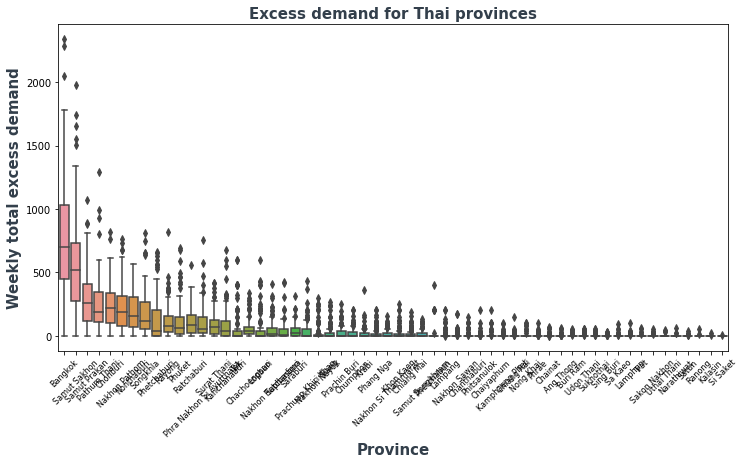

In [8]:
# # a4_dims = (24, 16)
# # a4_dims = (16, 12)
# a4_dims = (12, 6)
# fig, ax = plt.subplots(figsize=a4_dims)

# df['total_demand'] = df['total_demand'].astype(float)
# df['name_len'] = df['province'].apply(len)
# df.sort_values('name_len', inplace=True)
# bxplot = sns.boxplot(data=df, x='province', y='total_demand', order=plot_order)
# for item in bxplot.get_xticklabels():
#     item.set_rotation(45)
#     item.set_fontsize(8) 
# plt.ylabel('Weekly total excess demand', fontsize=15, fontweight='black', color = '#333F4B')
# plt.xlabel('Province', fontsize=15, fontweight='black', color = '#333F4B')
# plt.title('Excess demand for Thai provinces', fontsize=15, fontweight='black', color = '#333F4B')    
# plt.savefig('../../../plots/paper/demand_by_province.jpg', bbox_inches='tight')
# plt.show()

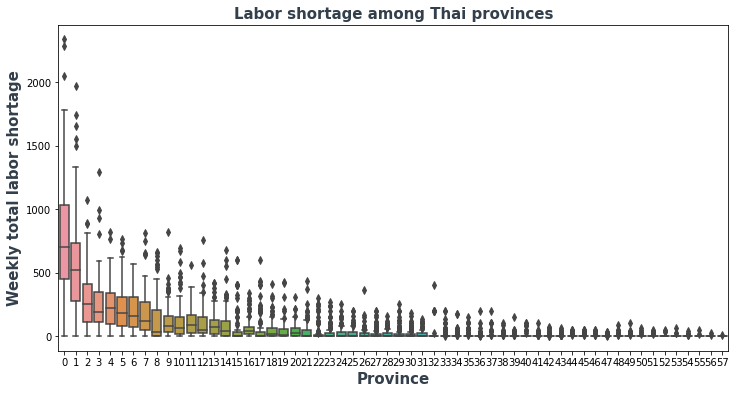

In [27]:
# a4_dims = (24, 16)
# a4_dims = (16, 12)
a4_dims = (12, 6)
fig, ax = plt.subplots(figsize=a4_dims)

df['total_demand'] = df['total_demand'].astype(float)
df['name_len'] = df['province'].apply(len)
df.sort_values('name_len', inplace=True)
bxplot = sns.boxplot(data=df, x='province', y='total_demand', order=plot_order)
tick_locs = range(df.province.nunique())
plt.xticks(ticks=tick_locs, labels=tick_locs)
plt.ylabel('Weekly total labor shortage', fontsize=15, fontweight='black', color = '#333F4B')
plt.xlabel('Province', fontsize=15, fontweight='black', color = '#333F4B')
plt.title('Labor shortage among Thai provinces', fontsize=15, fontweight='black', color = '#333F4B')    
plt.savefig('../../../plots/paper/demand_by_province_nolegend.jpg', bbox_inches='tight')
plt.show()

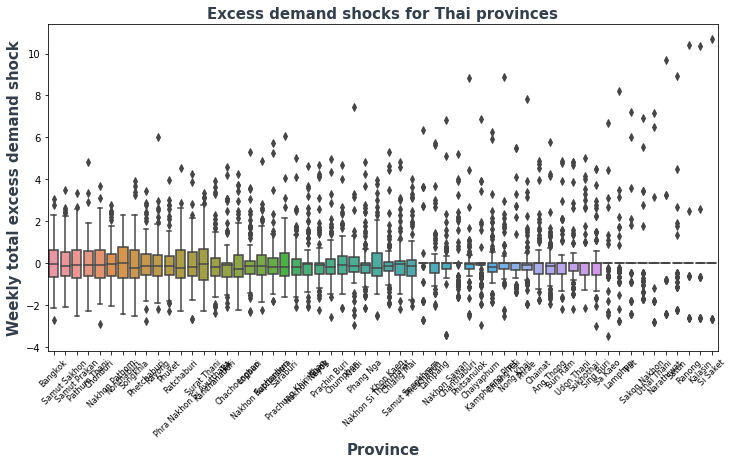

In [9]:
# # a4_dims = (16, 12)
# a4_dims = (12, 6)
# fig, ax = plt.subplots(figsize=a4_dims)

# df['demand_shock'] = df['demand_shock'].astype(float)
# bxplot = sns.boxplot(data=df, x='province', y='demand_shock', order=plot_order)
# for item in bxplot.get_xticklabels():
#     item.set_rotation(45)
#     item.set_fontsize(8) 
# plt.ylabel('Weekly total excess demand shock', fontsize=15, fontweight='black', color = '#333F4B')
# plt.xlabel('Province', fontsize=15, fontweight='black', color = '#333F4B')
# plt.title('Excess demand shocks for Thai provinces', fontsize=15, fontweight='black', color = '#333F4B')    
# plt.savefig('../../../plots/paper/demand_shock_by_province.jpg', bbox_inches='tight')
# plt.show()

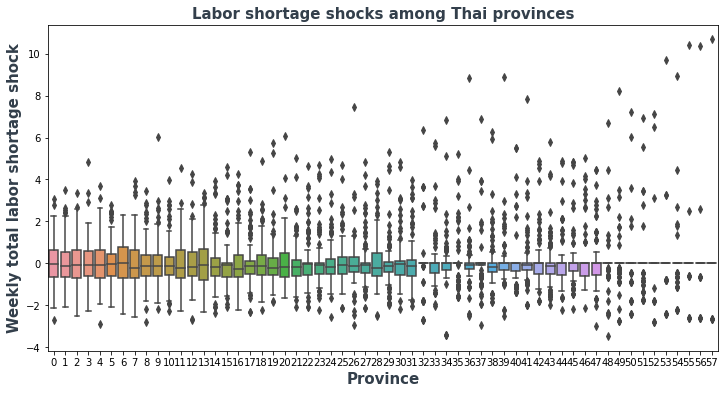

In [28]:
# a4_dims = (16, 12)
a4_dims = (12, 6)
fig, ax = plt.subplots(figsize=a4_dims)

df['demand_shock'] = df['demand_shock'].astype(float)
bxplot = sns.boxplot(data=df, x='province', y='demand_shock', order=plot_order)
tick_locs = range(df.province.nunique())
plt.xticks(ticks=tick_locs, labels=tick_locs)
plt.ylabel('Weekly total labor shortage shock', fontsize=15, fontweight='black', color = '#333F4B')
plt.xlabel('Province', fontsize=15, fontweight='black', color = '#333F4B')
plt.title('Labor shortage shocks among Thai provinces', fontsize=15, fontweight='black', color = '#333F4B')    
plt.savefig('../../../plots/paper/demand_shock_by_province_nolegend.jpg', bbox_inches='tight')
plt.show()

In [15]:
plot_data = df.groupby('province').mean().sort_values(by='total_demand', ascending=False).reset_index()
plot_data['idx'] = plot_data.index
plot_data['legend'] = plot_data.apply(lambda row: str(row.idx)+ ' - '+str(row.province), axis=1)
print('\n'.join(plot_data.legend))
# print(plot_data.province.values)

0 - Bangkok
1 - Samut Sakhon
2 - Samut Prakan
3 - Pathum Thani
4 - Chonburi
5 - Nakhon Pathom
6 - Nonthaburi
7 - Songkhla
8 - Phetchaburi
9 - Rayong
10 - Phuket
11 - Ratchaburi
12 - Phra Nakhon Si Ayutthaya
13 - Surat Thani
14 - Kanchanaburi
15 - Tak
16 - Chachoengsao
17 - Lopburi
18 - Nakhon Ratchasima
19 - Suphanburi
20 - Saraburi
21 - Prachuap Khiri Khan
22 - Nakhon Nayok
23 - Trang
24 - Prachin Buri
25 - Chumphon
26 - Krabi
27 - Phang Nga
28 - Nakhon Si Thammarat
29 - Khon Kaen
30 - Chiang Mai
31 - Samut Songkhram
32 - Phetchabun
33 - Lampang
34 - Nakhon Sawan
35 - Chanthaburi
36 - Phitsanulok
37 - Chaiyaphum
38 - Kamphaeng Phet
39 - Chiang Rai
40 - Nong Khai
41 - Phrae
42 - Chainat
43 - Ang Thong
44 - Buri Ram
45 - Udon Thani
46 - Sukhothai
47 - Sing Buri
48 - Sa Kaeo
49 - Lamphun
50 - Trat
51 - Sakon Nakhon
52 - Uthai Thani
53 - Narathiwat
54 - Satun
55 - Ranong
56 - Kalasin
57 - Si Saket


## other shock periods

In [10]:
wv_data_file = 'wv_cases1'
df = wv1
df['demand_shock'] = None
period_length = 8

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    demand_data_points = df.loc[prov_row_idx, 'total_demand'].values
    std_demand = np.std(demand_data_points)
    df.loc[[0, 1], 'demand_shock'] = np.nan # need at least two points to fit a line
    
#     i = 0
    for time_pointer in range(2, len(prov_row_idx)):
        y = demand_data_points[max(0, time_pointer-period_length):time_pointer]
        expected_demand = np.mean(y)
        demand_shock = demand_data_points[time_pointer] - expected_demand
#         print(x, y, expected_demand, demand_shock)
        df.loc[prov_row_idx[time_pointer], 'demand_shock'] = demand_shock/std_demand

#         i+=1
#         if i>3: break

    
print(df.shape)


(6554, 60)


In [11]:

    # create placeholder
for offset in range(1, 9):
    df['demand_shock_plus_%s' % offset] = None
# shift IV the other way by up to 2 months    
for offset in range(1, 9):
    df['demand_shock_minus_%s' % offset] = None

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 

    for offset in range(1, 9):
        df.loc[prov_row_idx, 'demand_shock_plus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(offset)
    # shift IV the other way by up to 2 months    
    for offset in range(1, 9):
        df.loc[prov_row_idx, 'demand_shock_minus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(-offset)

print(df.shape)

(6554, 60)


In [12]:
def yr_wk_to_float(yr_wk):
    yr, wk = yr_wk.split('-')
    return int(yr) + float(wk)/100

df['yr_wk_float'] = df.year_week.apply(yr_wk_to_float)

In [13]:
wv_data_file = 'wv_cases1'

df.to_csv(
    data_dir + 'regression_data_%s_causal_ma_detrend_8w_20210301.csv' % wv_data_file, 
    index=False)
df.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_plus_8,demand_shock_minus_1,demand_shock_minus_2,demand_shock_minus_3,demand_shock_minus_4,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,0,0.983368,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,2018.02
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,0,0.983368,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,-0.307303,2018.03
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,0.983368,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,-0.307303,-0.307303,2018.04
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,-0.307303,-0.307303,-0.307303,2018.05
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,-0.196674,-0.163895,1.33457,-0.307303,-0.307303,-0.307303,-0.307303,-0.184382,2018.06


In [14]:
wv_data_file = 'wv_cases1'
df = wv1
df['demand_shock'] = None
period_length = 12

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    demand_data_points = df.loc[prov_row_idx, 'total_demand'].values
    std_demand = np.std(demand_data_points)
    df.loc[[0, 1], 'demand_shock'] = np.nan # need at least two points to fit a line
    
#     i = 0
    for time_pointer in range(2, len(prov_row_idx)):
        y = demand_data_points[max(0, time_pointer-period_length):time_pointer]
        expected_demand = np.mean(y)
        demand_shock = demand_data_points[time_pointer] - expected_demand
#         print(x, y, expected_demand, demand_shock)
        df.loc[prov_row_idx[time_pointer], 'demand_shock'] = demand_shock/std_demand

#         i+=1
#         if i>3: break

    
print(df.shape)


(6554, 60)


In [15]:

    # create placeholder
for offset in range(1, 9):
    df['demand_shock_plus_%s' % offset] = None
# shift IV the other way by up to 2 months    
for offset in range(1, 9):
    df['demand_shock_minus_%s' % offset] = None

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 

    for offset in range(1, 9):
        df.loc[prov_row_idx, 'demand_shock_plus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(offset)
    # shift IV the other way by up to 2 months    
    for offset in range(1, 9):
        df.loc[prov_row_idx, 'demand_shock_minus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(-offset)

print(df.shape)

(6554, 60)


In [16]:
def yr_wk_to_float(yr_wk):
    yr, wk = yr_wk.split('-')
    return int(yr) + float(wk)/100

df['yr_wk_float'] = df.year_week.apply(yr_wk_to_float)

In [17]:
wv_data_file = 'wv_cases1'

df.to_csv(
    data_dir + 'regression_data_%s_causal_ma_detrend_12w_20210301.csv' % wv_data_file, 
    index=False)
df.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_plus_8,demand_shock_minus_1,demand_shock_minus_2,demand_shock_minus_3,demand_shock_minus_4,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,0,0.983368,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,2018.02
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,0,0.983368,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,-0.273158,2018.03
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,0.983368,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,-0.273158,-0.245842,2018.04
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,-0.245842,-0.196674,-0.163895,1.33457,-0.307303,-0.273158,-0.245842,-0.223493,2018.05
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,-0.196674,-0.163895,1.33457,-0.307303,-0.273158,-0.245842,-0.223493,-0.204868,2018.06


In [22]:
wv_data_file = 'wv_cases1'
'regression_data_%s_causal_ma_detrend_12w_20210301.csv' % wv_data_file

'regression_data_wv_cases1_causal_ma_detrend_12w_20210301.csv'

## std of 12 weeks

In [11]:
wv_data_file = 'wv_cases1'
df = wv1
df['demand_shock'] = None
period_length = 8
eps = 1e-6

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    demand_data_points = df.loc[prov_row_idx, 'total_demand'].values
#     std_demand = np.std(demand_data_points)
    df.loc[[0, 1, 2, 3], 'demand_shock'] = np.nan # need at least two points to fit a line
    
#     i = 0
    for time_pointer in range(4, len(prov_row_idx)):
        y = demand_data_points[max(0, time_pointer-period_length):time_pointer]
        expected_demand = np.mean(y)
        demand_shock = demand_data_points[time_pointer] - expected_demand
        running_std_demand = np.std(y)
#         print(x, y, expected_demand, demand_shock)
        df.loc[prov_row_idx[time_pointer], 'demand_shock'] = demand_shock/(running_std_demand+eps)

#         i+=1
#         if i>3: break

    
print(df.shape)


(6554, 44)


In [12]:

    # create placeholder
for offset in range(1, 9):
    df['demand_shock_plus_%s' % offset] = None
# shift IV the other way by up to 2 months    
for offset in range(1, 9):
    df['demand_shock_minus_%s' % offset] = None

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 

    for offset in range(1, 9):
        df.loc[prov_row_idx, 'demand_shock_plus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(offset)
    # shift IV the other way by up to 2 months    
    for offset in range(1, 9):
        df.loc[prov_row_idx, 'demand_shock_minus_%s' % offset] = df.loc[prov_row_idx, 'demand_shock'].shift(-offset)

print(df.shape)

(6554, 44)


In [13]:
def yr_wk_to_float(yr_wk):
    yr, wk = yr_wk.split('-')
    return int(yr) + float(wk)/100

df['yr_wk_float'] = df.year_week.apply(yr_wk_to_float)

In [14]:
wv_data_file = 'wv_cases1'

df.to_csv(
    data_dir + 'regression_data_%s_causal_ma_detrend_8w_std_20210217.csv' % wv_data_file, 
    index=False)
df.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_plus_8,demand_shock_minus_1,demand_shock_minus_2,demand_shock_minus_3,demand_shock_minus_4,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,NaN,NaN,-0.57735,-0.5,-0.447213,3.87836,-0.562544,2018.02
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,NaN,NaN,-0.57735,-0.5,-0.447213,3.87836,-0.562544,-0.562544,2018.03
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,NaN,-0.57735,-0.5,-0.447213,3.87836,-0.562544,-0.562544,-0.562544,2018.04
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,-0.57735,-0.5,-0.447213,3.87836,-0.562544,-0.562544,-0.562544,-0.562544,2018.05
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,-0.5,-0.447213,3.87836,-0.562544,-0.562544,-0.562544,-0.562544,-0.377964,2018.06


In [24]:
df[pd.isnull(df['demand_shock'])]['year_week'].value_counts()

2018-05    58
2018-02    58
2018-03    58
2018-04    58
Name: year_week, dtype: int64

In [23]:
df[pd.isnull(df['demand_shock'])]['province'].value_counts()

Prachuap Khiri Khan         4
Sakon Nakhon                4
Saraburi                    4
Phitsanulok                 4
Nonthaburi                  4
Ang Thong                   4
Phrae                       4
Satun                       4
Lamphun                     4
Phuket                      4
Kalasin                     4
Sukhothai                   4
Trat                        4
Samut Prakan                4
Tak                         4
Sa Kaeo                     4
Uthai Thani                 4
Kanchanaburi                4
Songkhla                    4
Nakhon Nayok                4
Ranong                      4
Nakhon Si Thammarat         4
Nakhon Pathom               4
Chiang Mai                  4
Chumphon                    4
Si Saket                    4
Khon Kaen                   4
Rayong                      4
Prachin Buri                4
Chaiyaphum                  4
Chonburi                    4
Nakhon Ratchasima           4
Samut Sakhon                4
Trang     

# bigger provinces

In [2]:
df = pd.read_csv(data_dir+'regression_data_wv_cases1_causal_ma_detrend_20210301.csv')
by_prov_counts = df.groupby('province').sum()['wv_count'].to_dict()
print(by_prov_counts)
lg_provs_40 = [prov for prov in by_prov_counts.keys() if by_prov_counts[prov]>=40]
df = df[df.province.isin(lg_provs_40)]
wv_data_file_lg_prov = 'regression_data_wv_cases1_causal_ma_detrend__province_40_20210301.csv'
df.to_csv(data_dir + wv_data_file_lg_prov)

{'Ang Thong': 1.0, 'Bangkok': 2363.0, 'Buri Ram': 4.0, 'Chachoengsao': 180.0, 'Chainat': 1.0, 'Chaiyaphum': 3.0, 'Chanthaburi': 14.0, 'Chiang Mai': 63.0, 'Chiang Rai': 20.0, 'Chonburi': 843.0, 'Chumphon': 358.0, 'Kalasin': 0.0, 'Kamphaeng Phet': 1.0, 'Kanchanaburi': 102.0, 'Khon Kaen': 9.0, 'Krabi': 30.0, 'Lampang': 5.0, 'Lamphun': 2.0, 'Lopburi': 201.0, 'Nakhon Nayok': 20.0, 'Nakhon Pathom': 210.0, 'Nakhon Ratchasima': 10.0, 'Nakhon Sawan': 59.0, 'Nakhon Si Thammarat': 51.0, 'Narathiwat': 8.0, 'Nong Khai': 3.0, 'Nonthaburi': 118.0, 'Pathum Thani': 274.0, 'Phang Nga': 28.0, 'Phetchabun': 6.0, 'Phetchaburi': 121.0, 'Phitsanulok': 2.0, 'Phra Nakhon Si Ayutthaya': 93.0, 'Phrae': 2.0, 'Phuket': 224.0, 'Prachin Buri': 9.0, 'Prachuap Khiri Khan': 112.0, 'Ranong': 152.0, 'Ratchaburi': 27.0, 'Rayong': 102.0, 'Sa Kaeo': 0.0, 'Sakon Nakhon': 3.0, 'Samut Prakan': 677.0, 'Samut Sakhon': 1700.0, 'Samut Songkhram': 21.0, 'Saraburi': 65.0, 'Satun': 13.0, 'Si Saket': 1.0, 'Sing Buri': 2.0, 'Songkhla':

In [3]:
df = pd.read_csv(data_dir+'regression_data_wv_cases1_causal_ma_detrend_20210301.csv')
# by_prov_counts = df.groupby('province').sum()['wv_count'].to_dict()
lg_provs_20 = [prov for prov in by_prov_counts.keys() if by_prov_counts[prov]>=20]
df = df[df.province.isin(lg_provs_20)]
wv_data_file_lg_prov = 'regression_data_wv_cases1_causal_ma_detrend__province_20_20210301.csv'
df.to_csv(data_dir + wv_data_file_lg_prov)

In [4]:
# by province
for prov in lg_provs_40:
    df[df.province==prov].to_csv(data_dir + 'regression_data_wv_cases1_causal_ma_detrend_%s_20210301.csv' % prov)

In [5]:
lg_provs_40

['Bangkok',
 'Chachoengsao',
 'Chiang Mai',
 'Chonburi',
 'Chumphon',
 'Kanchanaburi',
 'Lopburi',
 'Nakhon Pathom',
 'Nakhon Sawan',
 'Nakhon Si Thammarat',
 'Nonthaburi',
 'Pathum Thani',
 'Phetchaburi',
 'Phra Nakhon Si Ayutthaya',
 'Phuket',
 'Prachuap Khiri Khan',
 'Ranong',
 'Rayong',
 'Samut Prakan',
 'Samut Sakhon',
 'Saraburi',
 'Songkhla',
 'Surat Thani',
 'Tak']

In [8]:
len(lg_provs_40)

24

In [6]:
df.head()

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_plus_8,demand_shock_minus_1,demand_shock_minus_2,demand_shock_minus_3,demand_shock_minus_4,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float
113,Bangkok,2018-02,620.0,0.181818,11.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,0.143174,0.148087,0.607963,1.032221,-1.114862,-0.417942,-0.083167,2018.02
114,Bangkok,2018-03,422.0,0.062500,32.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,0.143174,0.148087,0.607963,1.032221,-1.114862,-0.417942,-0.083167,0.663758,2018.03
115,Bangkok,2018-04,589.0,0.000000,13.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,0.148087,0.607963,1.032221,-1.114862,-0.417942,-0.083167,0.663758,0.463210,2018.04
116,Bangkok,2018-05,614.0,0.000000,10.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,0.607963,1.032221,-1.114862,-0.417942,-0.083167,0.663758,0.463210,0.917471,2018.05
117,Bangkok,2018-06,850.0,0.062500,32.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,1.032221,-1.114862,-0.417942,-0.083167,0.663758,0.463210,0.917471,-0.912734,2018.06


# extra iv labor abuse

In [15]:
df = pd.read_csv(
        data_dir + 'regression_data_wv_cases1_causal_ma_detrend_20210301.csv')
print(df.shape)
df.head()

(6554, 60)


,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_plus_8,demand_shock_minus_1,demand_shock_minus_2,demand_shock_minus_3,demand_shock_minus_4,demand_shock_minus_5,demand_shock_minus_6,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,NaN,NaN,0.000000,0.983368,-0.245842,-0.245842,-0.245842,1.229210,-0.368763,2018.02
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,NaN,0.000000,0.983368,-0.245842,-0.245842,-0.245842,1.229210,-0.368763,-0.368763,2018.03
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,NaN,0.983368,-0.245842,-0.245842,-0.245842,1.229210,-0.368763,-0.368763,-0.368763,2018.04
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,NaN,-0.245842,-0.245842,-0.245842,1.229210,-0.368763,-0.368763,-0.368763,-0.368763,2018.05
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,NaN,-0.245842,-0.245842,1.229210,-0.368763,-0.368763,-0.368763,-0.368763,0.000000,2018.06


In [18]:
df['perc_abuse_minus_1'] = None 
df['perc_abuse_minus_2'] = None 
df['perc_abuse_minus_3'] = None 
df['perc_abuse_minus_4'] = None    
df['perc_abuse_minus_5'] = None   
df['perc_abuse_minus_6'] = None   
df['perc_abuse_minus_7'] = None   
for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    df.loc[prov_row_idx, 'perc_abuse_minus_1'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-1)
    df.loc[prov_row_idx, 'perc_abuse_minus_2'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-2)
    df.loc[prov_row_idx, 'perc_abuse_minus_3'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-3)
    df.loc[prov_row_idx, 'perc_abuse_minus_4'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-4)
    df.loc[prov_row_idx, 'perc_abuse_minus_5'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-5)
    df.loc[prov_row_idx, 'perc_abuse_minus_6'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-6)
    df.loc[prov_row_idx, 'perc_abuse_minus_7'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-7)
df.head()    

,province,year_week,total_demand,perc_abuse,wv_count,ex_rate,fake_date,month,quarter,ex_rate_diff,...,demand_shock_minus_7,demand_shock_minus_8,yr_wk_float,perc_abuse_minus_1,perc_abuse_minus_2,perc_abuse_minus_3,perc_abuse_minus_4,perc_abuse_minus_5,perc_abuse_minus_6,perc_abuse_minus_7
0,Ang Thong,2018-02,0.0,0.0,0.0,5.00602,2018-01-08,2018-01,2018-1,-0.032813,...,1.229210,-0.368763,2018.02,0,0,0,0,0,0,0
1,Ang Thong,2018-03,0.0,0.0,0.0,5.02540,2018-01-15,2018-01,2018-1,0.019380,...,-0.368763,-0.368763,2018.03,0,0,0,0,0,0,0
2,Ang Thong,2018-04,0.0,0.0,0.0,5.03024,2018-01-22,2018-01,2018-1,0.004840,...,-0.368763,-0.368763,2018.04,0,0,0,0,0,0,0
3,Ang Thong,2018-05,10.0,0.0,0.0,5.03048,2018-01-29,2018-01,2018-1,0.000240,...,-0.368763,-0.368763,2018.05,0,0,0,0,0,0,0
4,Ang Thong,2018-06,0.0,0.0,0.0,5.08050,2018-02-05,2018-02,2018-1,0.050020,...,-0.368763,0.000000,2018.06,0,0,0,0,0,0,0


In [16]:
df[['province', 'perc_abuse', 'perc_abuse_minus_1','perc_abuse_minus_2','perc_abuse_minus_3','perc_abuse_minus_4','perc_abuse_minus_5']].\
     fillna(0).groupby('province').sum().head()

,perc_abuse,perc_abuse_minus_1,perc_abuse_minus_2,perc_abuse_minus_3,perc_abuse_minus_4,perc_abuse_minus_5
province,,,,,,
Ang Thong,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Bangkok,19.049831,18.868012,18.805512,18.805512,18.805512,18.743012
Buri Ram,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
Chachoengsao,16.334740,16.334740,16.334740,16.334740,16.334740,15.334740
Chainat,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
df.to_csv(
        data_dir + 'regression_data_%s_extra_iv_20210318.csv' % 'wv_cases1', 
        index=False)

In [18]:
data_dir + 'regression_data_%s_extra_iv_20210318.csv' % 'wv_cases1'

'/Users/boyuliu/pyprojects/Joann/Joann-Thailand-Project/notebooks/datasets/new_dataset/regression_data_wv_cases1_extra_iv_20210318.csv'

## other shock periods

In [23]:
df = pd.read_csv(
        data_dir + 'regression_data_wv_cases1_causal_ma_detrend_8w_20210301.csv')
print(df.shape)
df['perc_abuse_minus_1'] = None 
df['perc_abuse_minus_2'] = None 
df['perc_abuse_minus_3'] = None 
df['perc_abuse_minus_4'] = None    
df['perc_abuse_minus_5'] = None   
df['perc_abuse_minus_6'] = None   
df['perc_abuse_minus_7'] = None   
for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    df.loc[prov_row_idx, 'perc_abuse_minus_1'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-1)
    df.loc[prov_row_idx, 'perc_abuse_minus_2'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-2)
    df.loc[prov_row_idx, 'perc_abuse_minus_3'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-3)
    df.loc[prov_row_idx, 'perc_abuse_minus_4'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-4)
    df.loc[prov_row_idx, 'perc_abuse_minus_5'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-5)
    df.loc[prov_row_idx, 'perc_abuse_minus_6'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-6)
    df.loc[prov_row_idx, 'perc_abuse_minus_7'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-7)
df.to_csv(
        data_dir + 'regression_data_wv_cases1_causal_extra_iv_8w_20210318.csv', 
        index=False)

(6554, 60)


In [24]:
df = pd.read_csv(
        data_dir + 'regression_data_wv_cases1_causal_ma_detrend_12w_20210301.csv')
print(df.shape)
df['perc_abuse_minus_1'] = None 
df['perc_abuse_minus_2'] = None 
df['perc_abuse_minus_3'] = None 
df['perc_abuse_minus_4'] = None    
df['perc_abuse_minus_5'] = None   
df['perc_abuse_minus_6'] = None   
df['perc_abuse_minus_7'] = None   
for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    df.loc[prov_row_idx, 'perc_abuse_minus_1'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-1)
    df.loc[prov_row_idx, 'perc_abuse_minus_2'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-2)
    df.loc[prov_row_idx, 'perc_abuse_minus_3'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-3)
    df.loc[prov_row_idx, 'perc_abuse_minus_4'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-4)
    df.loc[prov_row_idx, 'perc_abuse_minus_5'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-5)
    df.loc[prov_row_idx, 'perc_abuse_minus_6'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-6)
    df.loc[prov_row_idx, 'perc_abuse_minus_7'] = df.loc[prov_row_idx, 'perc_abuse'].shift(-7)
df.to_csv(
        data_dir + 'regression_data_wv_cases1_causal_extra_iv_12w_20210318.csv', 
        index=False)

(6554, 60)


## sandbox

In [10]:
wv_data_file = 'wv_cases1'
df = wv1
df['demand_shock'] = None

for prov in df.province.unique():
    prov_row_idx = df[df.province==prov].index 
    demand_data_points = df.loc[prov_row_idx, 'total_demand'].values
    std_demand = np.std(demand_data_points)
    df.loc[[0, 1], 'demand_shock'] = np.nan # need at least two points to fit a line
    
    i = 0
    for time_pointer in range(2, len(prov_row_idx)):
        y = demand_data_points[max(0, time_pointer-4):time_pointer]
        expected_demand = np.mean(y)
        demand_shock = demand_data_points[time_pointer] - expected_demand
#         print(x, y, expected_demand, demand_shock)
        df.loc[prov_row_idx[time_pointer], 'demand_shock'] = demand_shock/std_demand
        import pdb; pdb.set_trace()
        i+=1
        if i>3: break

    
print(df.shape)


> <ipython-input-10-c68b0ace961a>(19)<module>()
-> i+=1
(Pdb) n
> <ipython-input-10-c68b0ace961a>(20)<module>()
-> if i>3: break
(Pdb) n
> <ipython-input-10-c68b0ace961a>(12)<module>()
-> for time_pointer in range(2, len(prov_row_idx)):
(Pdb) y
array([0., 0.])
(Pdb) expected_demand
0.0
(Pdb) demand_shock
0.0
(Pdb) n
> <ipython-input-10-c68b0ace961a>(13)<module>()
-> y = demand_data_points[max(0, time_pointer-4):time_pointer]
(Pdb) n
> <ipython-input-10-c68b0ace961a>(14)<module>()
-> expected_demand = np.mean(y)
(Pdb) n
> <ipython-input-10-c68b0ace961a>(15)<module>()
-> demand_shock = demand_data_points[time_pointer] - expected_demand
(Pdb) n
> <ipython-input-10-c68b0ace961a>(17)<module>()
-> df.loc[prov_row_idx[time_pointer], 'demand_shock'] = demand_shock/std_demand
(Pdb) n
> <ipython-input-10-c68b0ace961a>(18)<module>()
-> import pdb; pdb.set_trace()
(Pdb) demand_shock
10.0
(Pdb) expected_demand
0.0
(Pdb) n
> <ipython-input-10-c68b0ace961a>(19)<module>()
-> i+=1
(Pdb) n
> <ipython-in

BdbQuit: 